In [ ]:
# Libraries required prior running code (run in case not installed on your env):
# !pip install \
#     numpy>=1.26.4 \
#     pandas>=2.2.2 \
#     matplotlib>=3.9.2 \
#     seaborn>=0.13.2 \
#     scipy>=1.13.1 \
#     statsmodels>=0.14.2 \
#     pingouin>=0.5.5

In [64]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, shapiro, spearmanr, kendalltau
from statsmodels.stats.stattools import jarque_bera 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence
import pingouin as pg

## Reproduction of Determinants of apartment prices in Warsaw by Xinyue Fang

Study made by Xinyue is focused on explaining how different determinants are affecting house price on micro level. Research focuses on factors that influence the price of apartments in Warsaw, following hypothesis are formulated:
1. Influence of apartment type on it's price, it is assumed that tenement apartments should be the cheapest.
2. Non-linear relationship between size and price, it is expected for price to rise rapidly with the increase of flat size.
3. Positive relationship between floor and price - the higher the apartment is situated the higher the price. Lowest floor flats should be the cheapest.
4. Negative relationship between distance from city center and price.
5. Positive relationship between number of ammenities and price.
6. Ownership relationship between type of ownership an price.
7. Positive relationship between existance of elavator and price.
8. Positive rlationship between existance of balcony and price.

* Original research was done in R - code is attached om Determinants of apartment prices in Warsaw.R in working directory of this project.

* We have two notebooks - this one which uses original data and project_reproduction - extension which uses extended version of data (more on that further down below).

## Using AI ##
Prompting was helpful in translating parts of the code used in this research. Model ChatGPT4o was used during this work. Examples of prompts used:
* 'create code which would install all of those libraries: {libraries used in this research}', 'add those versions of libraries to previosly generated code'
* 'Please translate this code: {some R code} into python code. I want it to be put into jupyter notebook. Each of the variables should have their code in seperate cells.'


## Methods helpful in further steps ##

Methods for plotting histograms and box plots:

In [4]:
def plot_historgram(df: pd.DataFrame, column: str, xlabel: str, title: str):
    x = df[column].dropna()
    plt.hist(x, bins=20, color='blue', density=True)
    xfit = np.linspace(x.min(), x.max(), 1000)
    yfit = norm.pdf(xfit, loc=x.mean(), scale=x.std())
    plt.plot(xfit, yfit, 'r', linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)

In [5]:
def plot_boxplot(df: pd.DataFrame, column: str):
    y = df[column].dropna()
    sns.boxplot(y)
    plt.title("Boxplot")
    plt.ylabel(column)
    plt.show()

## Handling Data ##

Original dataset was taken from https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland . Research done by Xinyue was done based on data from November 2023 for aparments in Warsaw. Given the abilities of python which we are going to use, we decided to create two separate datasets - one just to reproduce the research and extend one with data since November 2023 up until June 2024. It is also worth noting that dataset on kaggle is structered as follow: datasets inlucding appartments prices in multiple cities from 08.2023 to 06.2024 are saved in csv files for each month separately. 

**Initially we took following aproach to prepare the data:**
1. Download data from aforementioned source and add csv files into source into data/source directory.
2. Recreate original dataset for November 2023 using transform_data_from_file() and create_dummy_variables() methods (those are currently only in extended version of this notebook) and drop id column.
3. Use methods aggregate aggregate_data() and create_dummy_variables() to generate extended dataset.

**But:**
* generated data, even after transformations, showed some differences in number of rows and and in results for reproduced regression. That's because there were no R codes for transforming the data and we couldn't adjust dataset accordignly. Fortunately author provided us with the original data, so this is the one used throught this notebook. In proejct_reproduction - extenstion.ipynb we use aforementioned methods and data only from kaggle for periods 11.2023 - 06.2024.

**Loading data from original file provided by author:**

In [6]:
Apartment = pd.read_excel('Apartment.xlsx')

In [7]:
Apartment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            2692 non-null   int64  
 1   squareMeters    2692 non-null   float64
 2   FloorType       2692 non-null   int64  
 3   centreDistance  2692 non-null   float64
 4   poiCount        2692 non-null   int64  
 5   ownership       2692 non-null   int64  
 6   hasBalcony      2692 non-null   int64  
 7   hasElevator     2692 non-null   int64  
 8   price           2692 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 189.4 KB


## Data description and visualization ##

Here we are focusing on recreating original research - visualizing data and checking if it's similar to what has been discovered previously. Additionally, for each variable we are running tests for extended dataset.

# Price - reproduction

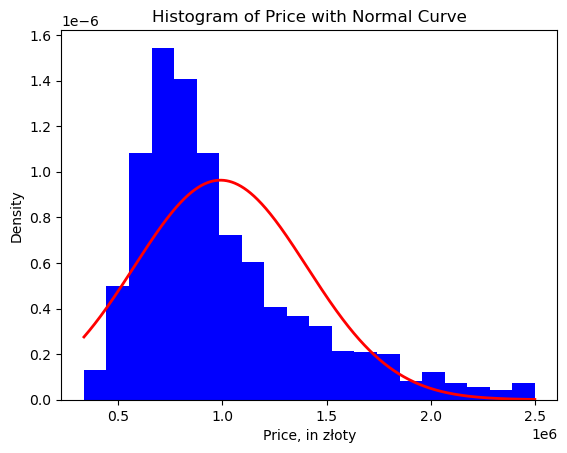

In [8]:
plot_historgram(Apartment, 'price', 'Price, in złoty', 'Histogram of Price with Normal Curve')

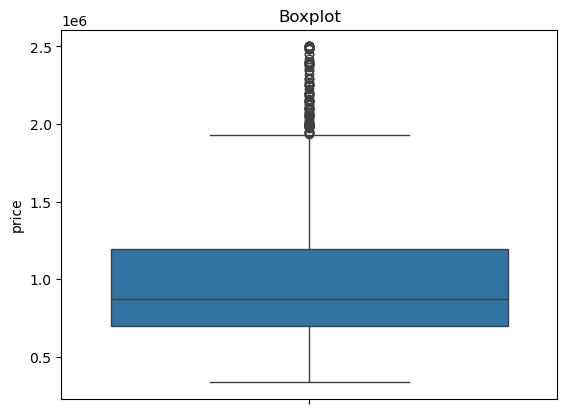

In [9]:
plot_boxplot(Apartment, 'price')

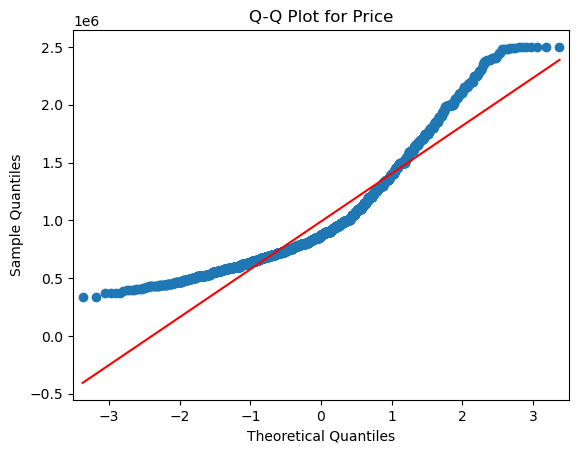

In [10]:
sm.qqplot(Apartment['price'], line='s')
plt.title("Q-Q Plot for Price")
plt.show()

In [11]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartment['price']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartment['price']))

Jarque-Bera Test:
(979.1481783518628, 2.4025619130737517e-213, 1.2932924582014322, 4.4279295272840855)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.8882190054114916, pvalue=2.0357849374624634e-40)


We performed the sama tests, and we can reject the null hypothesis that the density distribution is normal as in the original research.

 P-values are even smaller than for original dataset, thus confirming that density distribution is not normal.

# Square Meters - reproduction

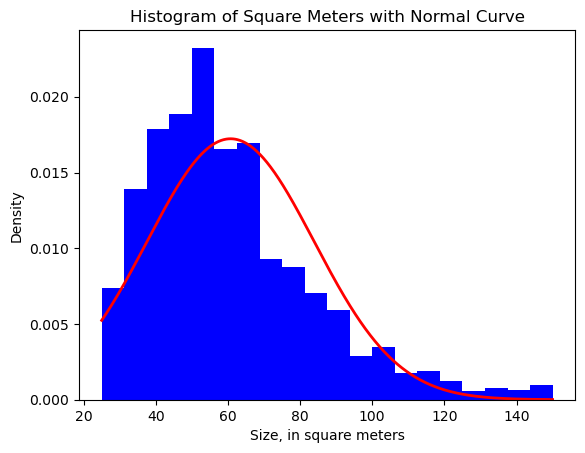

In [12]:
plot_historgram(Apartment, 'squareMeters', 'Size, in square meters', 'Histogram of Square Meters with Normal Curve')

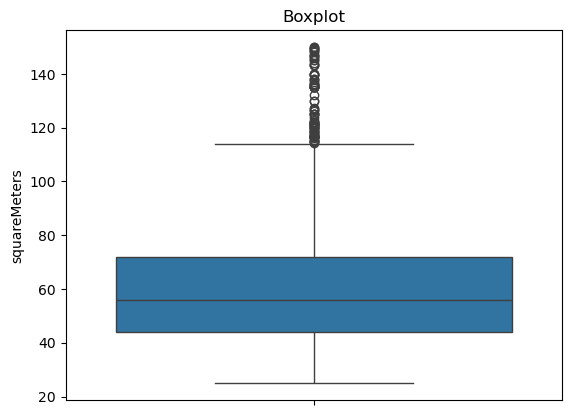

In [13]:
plot_boxplot(Apartment, 'squareMeters')

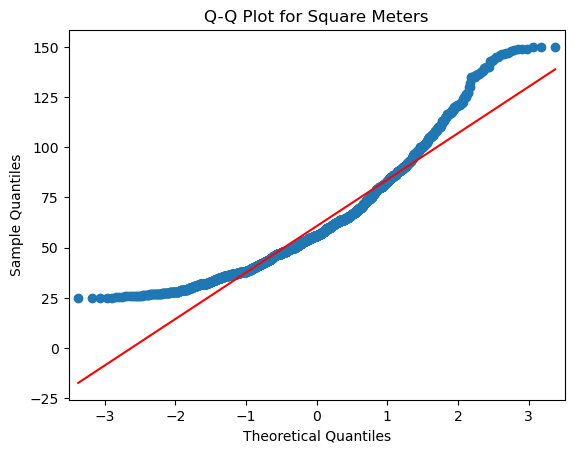

In [14]:
sm.qqplot(Apartment['squareMeters'], line='s')
plt.title("Q-Q Plot for Square Meters")
plt.show()

In [15]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartment['squareMeters']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartment['squareMeters']))

Jarque-Bera Test:
(784.6573433563725, 4.109819966574456e-171, 1.121494485736472, 4.401591845508675)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9258305926103148, pvalue=1.49516907112125e-34)


As in original research we can reject null hypothesis that density distribution is normal.

# Distance from city centre - reproduction

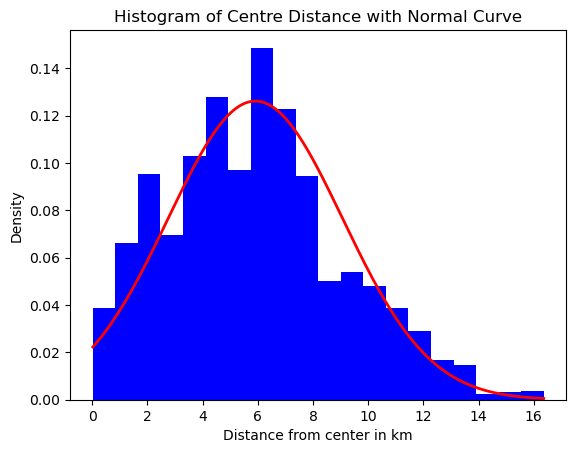

In [16]:
plot_historgram(Apartment, 'centreDistance', 'Distance from center in km',
                'Histogram of Centre Distance with Normal Curve')

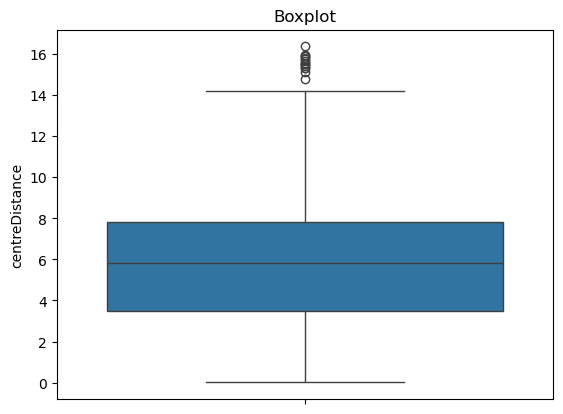

In [17]:
plot_boxplot(Apartment, 'centreDistance')

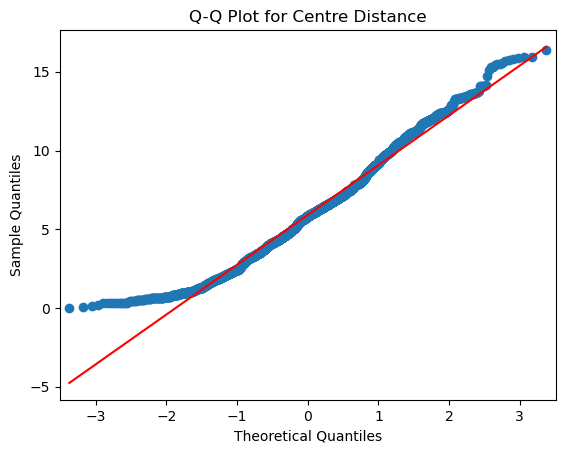

In [18]:
sm.qqplot(Apartment['centreDistance'], line='s')
plt.title("Q-Q Plot for Centre Distance")
plt.show()

In [19]:
print("Jarque-Bera Test:")
print(jarque_bera(Apartment['centreDistance']))

print("\nShapiro-Wilk Test:")
print(shapiro(Apartment['centreDistance']))

Jarque-Bera Test:
(88.99357909081512, 4.734671344806688e-20, 0.4285896975133029, 2.7578257851545436)

Shapiro-Wilk Test:
ShapiroResult(statistic=0.9792842972099155, pvalue=2.2474107565810474e-19)


Again as in original research we can reject null hypothesis that density distribution is normal.


Correlation - Price vs squareMeters

In [20]:
# Spearman correlation: price vs squareMeters
print("Spearman Correlation: Price vs Square Meters")
print(spearmanr(Apartment['price'], Apartment['squareMeters']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(Apartment['price'], Apartment['squareMeters']))

Spearman Correlation: Price vs Square Meters
SignificanceResult(statistic=0.7774666607723111, pvalue=0.0)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=0.5841106740499615, pvalue=0.0)


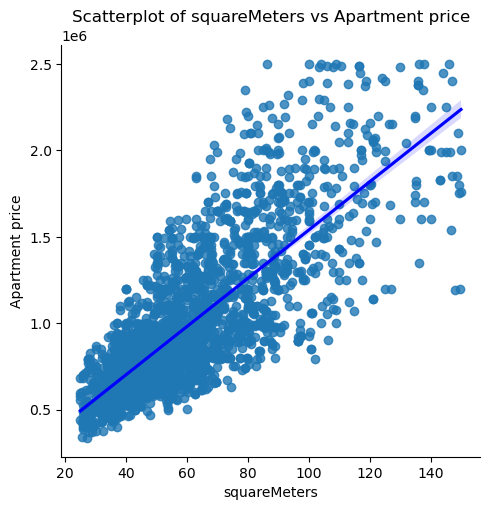

In [21]:
sns.lmplot(x='squareMeters', y='price', data=Apartment, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

Correlation - price vs distance from city center

In [22]:
# Spearman correlation: price vs centreDistance
print("\nSpearman Correlation: Price vs Centre Distance")
print(spearmanr(Apartment['price'], Apartment['centreDistance']))

# Kendall correlation: price vs centreDistance
print("Kendall Correlation: Price vs Centre Distance")
print(kendalltau(Apartment['price'], Apartment['centreDistance']))


Spearman Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.1602719093535959, pvalue=5.965908960665938e-17)
Kendall Correlation: Price vs Centre Distance
SignificanceResult(statistic=-0.10627796282938166, pvalue=1.6338991165323887e-16)


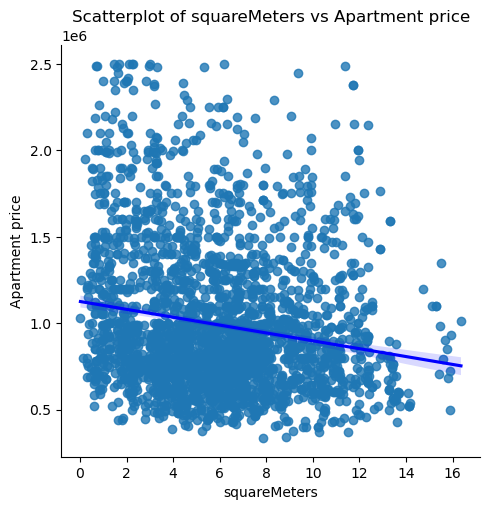

In [23]:
sns.lmplot(x='centreDistance', y='price', data=Apartment, line_kws={"color": "blue"})
plt.title("Scatterplot of squareMeters vs Apartment price")
plt.xlabel("squareMeters")
plt.ylabel("Apartment price")
plt.show()

# Dummy Variables - reproduction

Price Summary by Type:
       count          mean            std       min       25%        50%  \
type                                                                       
1      383.0  1.154426e+06  505288.852497  405000.0  780000.0   998000.0   
2     1522.0  8.527869e+05  303792.239252  335000.0  660000.0   780000.0   
3      787.0  1.177299e+06  447190.990921  340800.0  833390.0  1100000.0   

            75%        max  
type                        
1     1455000.0  2500000.0  
2      950000.0  2500000.0  
3     1455000.0  2500000.0  


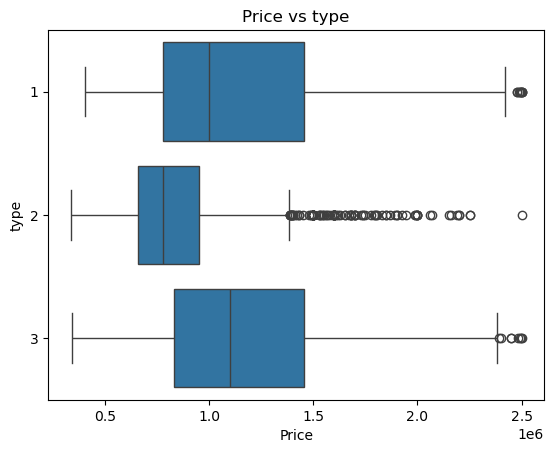

Price Summary by Floortype:
            count          mean            std       min       25%       50%  \
FloorType                                                                      
0           570.0  9.607798e+05  400924.589328  399000.0  683500.0  828000.0   
1           824.0  1.010439e+06  406648.535697  340800.0  723750.0  895888.0   
2          1298.0  9.910435e+05  424135.985312  335000.0  695000.0  881000.0   

                 75%        max  
FloorType                        
0          1164250.0  2500000.0  
1          1220000.0  2500000.0  
2          1169750.0  2500000.0  


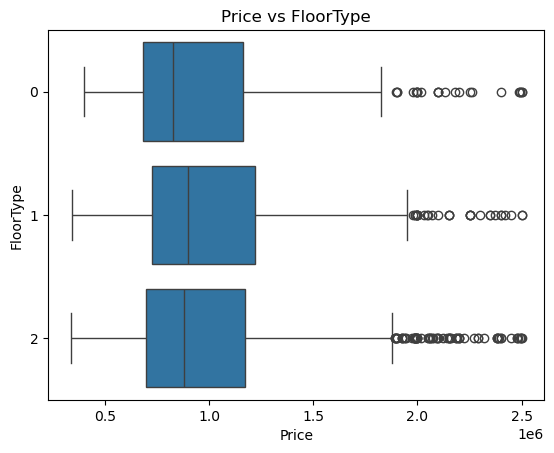

Price Summary by Ownership:
            count          mean            std       min       25%       50%  \
ownership                                                                      
0           381.0  8.519861e+05  339367.994942  375000.0  650000.0  769000.0   
1          2311.0  1.013420e+06  420994.932217  335000.0  710000.0  897000.0   

                 75%        max  
ownership                        
0           927000.0  2380000.0  
1          1220000.0  2500000.0  


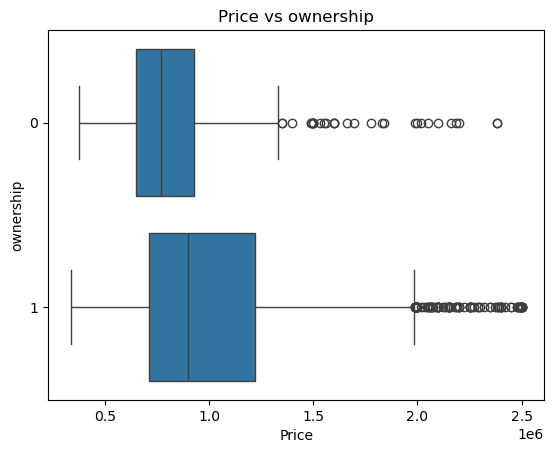

Price Summary by Poicount:
           count          mean            std       min        25%        50%  \
poiCount                                                                        
1         1546.0  9.428063e+05  375502.446049  335000.0  685000.00   845500.0   
2          768.0  9.913683e+05  413059.691303  375000.0  698776.25   867000.0   
3          378.0  1.184316e+06  502715.414851  439000.0  799000.00  1032000.0   

                75%        max  
poiCount                        
1         1100000.0  2499000.0  
2         1220000.0  2500000.0  
3         1488750.0  2500000.0  


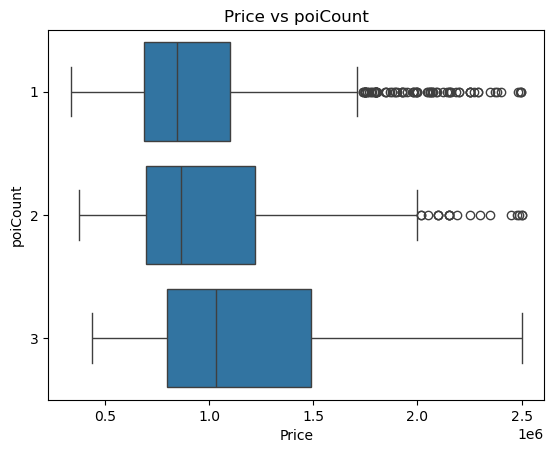

Price Summary by Hasbalcony:
             count          mean            std       min       25%       50%  \
hasBalcony                                                                      
0            861.0  9.422207e+05  401024.166888  335000.0  660000.0  829000.0   
1           1831.0  1.013309e+06  418454.510783  340800.0  720000.0  890000.0   

                  75%        max  
hasBalcony                        
0           1104950.0  2485350.0  
1           1217000.0  2500000.0  


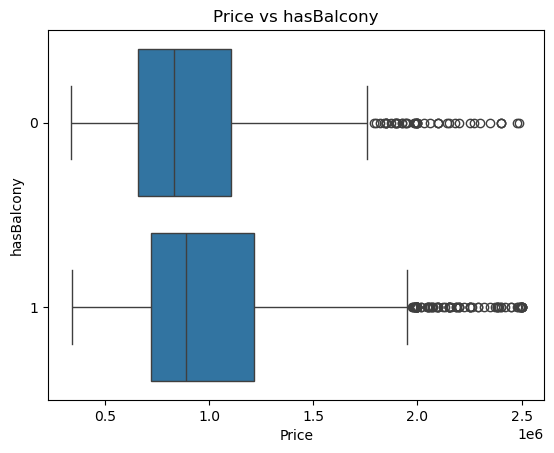

Price Summary by Haselevator:
              count          mean            std       min       25%  \
hasElevator                                                            
0             764.0  9.584553e+05  404734.703656  335000.0  681500.0   
1            1928.0  1.003299e+06  417332.150930  340800.0  708500.0   

                  50%        75%        max  
hasElevator                                  
0            840000.0  1110250.0  2500000.0  
1            890000.0  1200000.0  2500000.0  


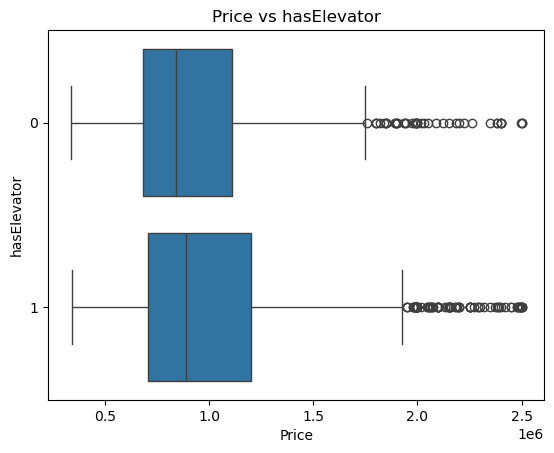

In [24]:
dummy_variables = ['type', 'FloorType', 'ownership', 'poiCount', 'hasBalcony', 'hasElevator']


def table(df: pd.DataFrame):
    for dummy in dummy_variables:
        print(f"Price Summary by {dummy.title()}:")
        print(df.groupby(dummy)['price'].describe())
        sns.boxplot(y=dummy, x='price', data=df, orient='h')
        plt.title(f"Price vs {dummy}")
        plt.xlabel("Price")
        plt.ylabel(dummy)
        plt.show()


table(Apartment)

In [25]:
datacorr = Apartment[["price", "squareMeters", "type", "FloorType",
                      "centreDistance", "poiCount", "ownership",
                      "hasBalcony", "hasElevator"]]

cor_matrix = datacorr.corr(numeric_only=True)
print(cor_matrix)

                   price  squareMeters      type  FloorType  centreDistance  \
price           1.000000      0.779981  0.117646   0.020029       -0.173839   
squareMeters    0.779981      1.000000  0.106610   0.067649        0.131084   
type            0.117646      0.106610  1.000000  -0.092726        0.263294   
FloorType       0.020029      0.067649 -0.092726   1.000000        0.044807   
centreDistance -0.173839      0.131084  0.263294   0.044807        1.000000   
poiCount        0.181826     -0.026246 -0.274118   0.005110       -0.542058   
ownership       0.135874      0.012662  0.086622  -0.008069        0.003341   
hasBalcony      0.080062      0.130568  0.170236  -0.030486        0.168919   
hasElevator     0.048818     -0.085928  0.392313  -0.193875       -0.012881   

                poiCount  ownership  hasBalcony  hasElevator  
price           0.181826   0.135874    0.080062     0.048818  
squareMeters   -0.026246   0.012662    0.130568    -0.085928  
type           -0.27

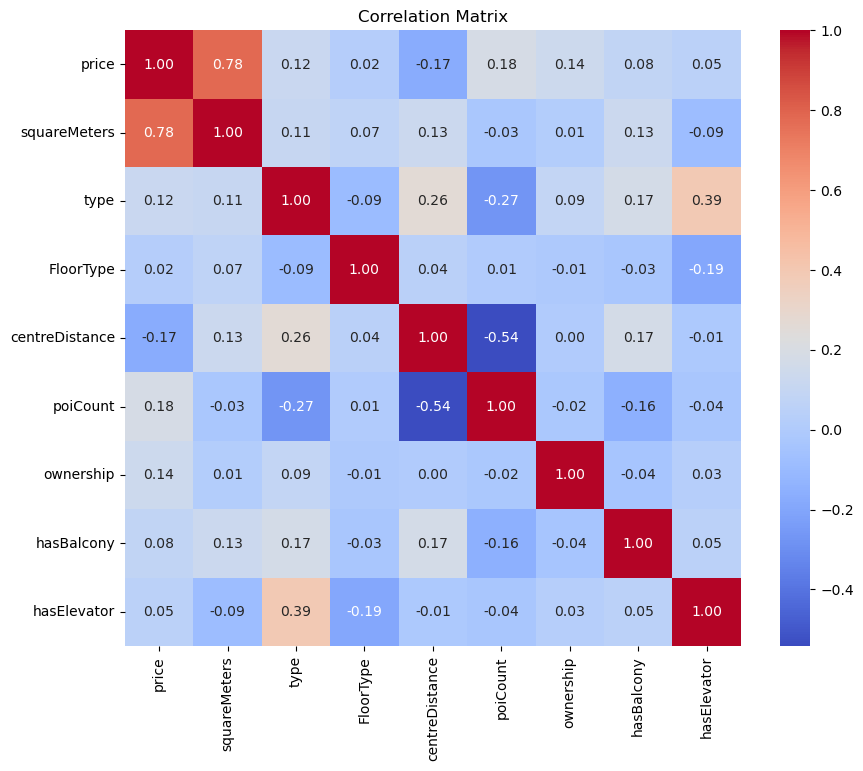

Significant Correlations with 'price' (p < 0.05):
       X               Y         r         p-unc
0  price    squareMeters  0.779981  0.000000e+00
4  price        poiCount  0.181826  1.926525e-21
3  price  centreDistance -0.173839  1.040788e-19
5  price       ownership  0.135874  1.448255e-12
1  price            type  0.117646  9.214302e-10
6  price      hasBalcony  0.080062  3.200572e-05
7  price     hasElevator  0.048818  1.130087e-02


In [26]:
# Correlation matrix with values
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

# With significance levels (p-values)
results = pg.pairwise_corr(datacorr, method='pearson')
sig_corrs = results[results['p-unc'] < 0.05]

# Filter to only rows where 'price' is one of the variables
price_corrs = sig_corrs[(sig_corrs['X'] == 'price') | (sig_corrs['Y'] == 'price')]

# Optional: sort by absolute correlation strength
price_corrs = price_corrs.copy()
price_corrs['abs_r'] = price_corrs['r'].abs()
price_corrs = price_corrs.sort_values('abs_r', ascending=False)

# Display cleaned result
print("Significant Correlations with 'price' (p < 0.05):")
print(price_corrs[['X', 'Y', 'r', 'p-unc']])

## REGRESSION

In [27]:
# Step 1: Ensure correct data types (convert to integers)
cols_to_int = ['type', 'FloorType', 'ownership', 'hasBalcony', 'hasElevator', 'poiCount']
Apartment[cols_to_int] = Apartment[cols_to_int].apply(pd.to_numeric, errors='coerce').astype('Int64')

# Step 2: Convert to categorical and rename categories (use existing values directly)
Apartment['type'] = Apartment['type'].astype('category')
Apartment['type'] = Apartment['type'].cat.rename_categories({1: 'tenement', 2: 'blockOfFlats', 3: 'apartmentBuilding'})

Apartment['FloorType'] = Apartment['FloorType'].astype('category')
Apartment['FloorType'] = Apartment['FloorType'].cat.rename_categories({0: 'low', 1: 'middle', 2: 'high'})

Apartment['ownership'] = Apartment['ownership'].astype('category')
Apartment['ownership'] = Apartment['ownership'].cat.rename_categories({0: 'cooperative', 1: 'condominium'})

Apartment['hasBalcony'] = Apartment['hasBalcony'].astype('category')
Apartment['hasBalcony'] = Apartment['hasBalcony'].cat.rename_categories({0: 'no', 1: 'yes'})

Apartment['hasElevator'] = Apartment['hasElevator'].astype('category')
Apartment['hasElevator'] = Apartment['hasElevator'].cat.rename_categories({0: 'no', 1: 'yes'})

Apartment['poiCount'] = Apartment['poiCount'].astype('category')
Apartment['poiCount'] = Apartment['poiCount'].cat.rename_categories({1: 'small', 2: 'medium', 3: 'large'})

print(Apartment.dtypes)
print(Apartment.head())


type              category
squareMeters       float64
FloorType         category
centreDistance     float64
poiCount          category
ownership         category
hasBalcony        category
hasElevator       category
price                int64
dtype: object
                type  squareMeters FloorType  centreDistance poiCount  \
0       blockOfFlats         62.20      high           10.31    small   
1       blockOfFlats         73.40    middle            5.68    large   
2           tenement         50.33    middle            2.41   medium   
3  apartmentBuilding         34.00       low           10.14    small   
4       blockOfFlats         48.07      high            0.67    large   

     ownership hasBalcony hasElevator   price  
0  condominium        yes          no  680000  
1  condominium        yes         yes  954000  
2  condominium        yes          no  880000  
3  condominium        yes         yes  650000  
4  cooperative         no         yes  720000  


In [28]:
print(Apartment.dtypes)
print(Apartment['type'].value_counts())

type              category
squareMeters       float64
FloorType         category
centreDistance     float64
poiCount          category
ownership         category
hasBalcony        category
hasElevator       category
price                int64
dtype: object
type
blockOfFlats         1522
apartmentBuilding     787
tenement              383
Name: count, dtype: int64


In [29]:
print(Apartment['FloorType'].value_counts())

FloorType
high      1298
middle     824
low        570
Name: count, dtype: int64


In [30]:
print(Apartment['poiCount'].value_counts())

poiCount
small     1546
medium     768
large      378
Name: count, dtype: int64


In [31]:
print(Apartment['ownership'].value_counts())

ownership
condominium    2311
cooperative     381
Name: count, dtype: int64


In [32]:
print(Apartment['hasBalcony'].value_counts())

hasBalcony
yes    1831
no      861
Name: count, dtype: int64


In [33]:
print(Apartment['hasElevator'].value_counts())

hasElevator
yes    1928
no      764
Name: count, dtype: int64


In [34]:
print(Apartment.isnull().sum())          # 检查缺失值
print(Apartment.dtypes)                  # 检查变量类型
print(Apartment.shape)                   # 查看行列数
print(Apartment.head())                  # 看前几行是否数据正常


type              0
squareMeters      0
FloorType         0
centreDistance    0
poiCount          0
ownership         0
hasBalcony        0
hasElevator       0
price             0
dtype: int64
type              category
squareMeters       float64
FloorType         category
centreDistance     float64
poiCount          category
ownership         category
hasBalcony        category
hasElevator       category
price                int64
dtype: object
(2692, 9)
                type  squareMeters FloorType  centreDistance poiCount  \
0       blockOfFlats         62.20      high           10.31    small   
1       blockOfFlats         73.40    middle            5.68    large   
2           tenement         50.33    middle            2.41   medium   
3  apartmentBuilding         34.00       low           10.14    small   
4       blockOfFlats         48.07      high            0.67    large   

     ownership hasBalcony hasElevator   price  
0  condominium        yes          no  680000  
1  co

In [35]:
# Initial linear regression model (equivalent to regression1)
regression1 = smf.ols('price ~ type + squareMeters + FloorType + centreDistance + poiCount + ownership + hasBalcony + hasElevator', data=Apartment).fit()
print(regression1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     757.3
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        17:27:23   Log-Likelihood:                -36736.
No. Observations:                2692   AIC:                         7.350e+04
Df Residuals:                    2680   BIC:                         7.357e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

* In the results of this first regression model, we find that the results are the same as those obtained by the original author in R, only the form is a bit different.
* Given significance level of 1%, non- significant variables are: type_apartment building, Floor type middle and floor type high, but as F-statistic shows all variables result in joint significance. R-squared is 0.757 and Adjusted R-squared is 0.756.

* In R, the power is 2:3, here we need to be aware that we should use the highest power 3 to get the same result like in R

In [36]:
# RESET test (fitted)
reset_fitted = linear_reset(regression1, power=3, use_f=True)
print("\nRESET test (fitted):", reset_fitted)

# RESET test (regressor)
reset_regressor = linear_reset(regression1, power=3, use_f=True)
print("\nRESET test (regressor):", reset_regressor)


RESET test (fitted): <F test: F=28021.699707245058, p=0.0, df_denom=2.69e+03, df_num=2>

RESET test (regressor): <F test: F=28021.699707245058, p=0.0, df_denom=2.69e+03, df_num=2>


* Here we get the same result as in the original paper， the first model rejects the assumption of linearity

* in regression2, we log-transformed the price and changed the forms of some of the independent variables as the author did. (Interaction terms and taking polynomials)

In [37]:
# Fitting a nonlinear model regression2
Apartment['log_price'] = np.log(Apartment['price'])
Apartment['squareMeters_2'] = Apartment['squareMeters']**2
Apartment['centreDistance_2'] = Apartment['centreDistance']**2
Apartment['centreDistance_3'] = Apartment['centreDistance']**3

formula2 = 'log_price ~ poly(squareMeters, 2, raw=True) + poly(centreDistance, 3, raw=True) + type + type:squareMeters + hasBalcony + poiCount + hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance'
regression2 = smf.ols('log_price ~ squareMeters + I(squareMeters ** 2) + centreDistance + I(centreDistance ** 2) + I(centreDistance ** 3) + type + type:squareMeters + hasBalcony + poiCount + hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance', data=Apartment).fit()
print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     615.5
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        17:27:23   Log-Likelihood:                 921.08
No. Observations:                2692   AIC:                            -1806.
Df Residuals:                    2674   BIC:                            -1700.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

* Here we almost get the same result as the author did. Only difference is that in the paper using R, there didn't show the coefficents for squareMeters and centreDistance, author thought this is because I use the polynomials to the both variables and 
the interactions. However, using Python, we saw the coefficients for them, and both of them are significant.

This difference is actually a difference between R and Python (statsmodels) in the way they handle multicollinearity and output regression results, especially with polynomial terms and interaction terms. If R finds that some variables are perfectly linearly correlated with other variables (i.e., the covariates are highly covariant), R automatically “discards” these variables and does not show their coefficients in the regression results (called the “aliased” parameter). The variables are considered redundant. In Python (statsmodels) the coefficients of all variables are displayed.

In [38]:
# RESET 
print("\nRESET test (fitted):", linear_reset(regression2, power=3, use_f=True))
print("\nRESET test (regressor):", linear_reset(regression2, power=3, use_f=True))


RESET test (fitted): <F test: F=17.260491887204665, p=3.563475905245173e-08, df_denom=2.67e+03, df_num=2>

RESET test (regressor): <F test: F=17.260491887204665, p=3.563475905245173e-08, df_denom=2.67e+03, df_num=2>


* In R, fit and regressor get different detection values, but in Python they are the same. This is because R and Python add variables differently, and there may be a simplifying logic within the Python implementation where the expansion of fitted and regressor coincide when the model contains polynomials and interaction terms, causing the two tests to “look” the same. (The more complex the model, the more likely this phenomenon is to occur)
* Here we still reject the assumption of linearty, different from the paper.

## DIAGNOSTIC TEST 

### Linearity

In [39]:
Apartment['squareMeters2'] = Apartment['squareMeters'] ** 2
Apartment['squareMeters3'] = Apartment['squareMeters'] ** 3
Apartment['centreDistance2'] = Apartment['centreDistance'] ** 2
Apartment['centreDistance3'] = Apartment['centreDistance'] ** 3

reset_model = smf.ols(
    'log_price ~ squareMeters + squareMeters2 + squareMeters3 + '
    'centreDistance + centreDistance2 + centreDistance3 + '
    'type + type:squareMeters + hasBalcony + poiCount + '
    'hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance',
    data=Apartment
).fit()

from statsmodels.stats.anova import anova_lm
anova_result = anova_lm(regression2, reset_model)
print(anova_result)


   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0    2674.0  79.507647      0.0       NaN       NaN       NaN
1    2673.0  79.507371      1.0  0.000277  0.009304  0.923163


* Couldn't update statsmodels to do regressor reset test
* So manually checking by adding non-linear variable squareMeters3.
* Difference in residual sum of squares (indicating how much additional variance is explained by the new variable) ss_diff = 0.000277 Very small, indicating that the new variable barely improves the fit of the model.
* The added variable do not significantly increase the explanatory power of the model, so it can be assumed that the model has no serious omitted variable bias (i.e., there are no serious violations of the linearity assumption) - at least from the point of view of the RESET test.

This is consistent with what the author got with type = “regressor” in R (the p-value is 0.016, greater than 0.01)

### Normality of residuals

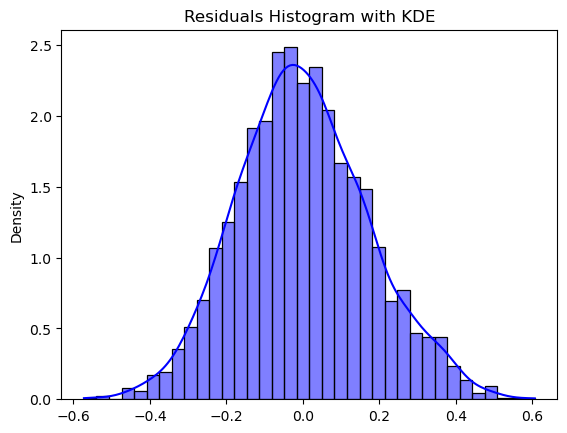

In [40]:
residuals = regression2.resid
sns.histplot(residuals, kde=True, color='blue', stat="density")
plt.title("Residuals Histogram with KDE")
plt.show()

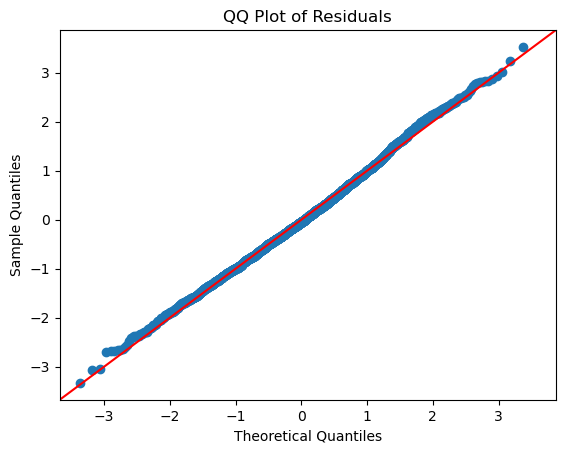

In [41]:
# QQ plot of residuals
sm.qqplot(regression2.resid, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

In [42]:
# Jarque-Bera test
jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
print("\nJarque-Bera test: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))


Jarque-Bera test: statistic = 14.4196, p-value = 0.0007


* We got the same plots and test results as the author did, the assumption of normality is rejected. However, author didn't conduct further modifications for the fact that from the test the distribution of residuals is not normal because of the law of large numbers. 

### Homoscedasticity

In [43]:
# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, regression2.model.exog)
print("\nBreusch-Pagan test:", lzip(['LM stat', 'LM p-value', 'F stat', 'F p-value'], bp_test))


Breusch-Pagan test: [('LM stat', 104.3839825498497), ('LM p-value', 1.3613379911601319e-14), ('F stat', 6.3452174978588785), ('F p-value', 6.661495175754691e-15)]


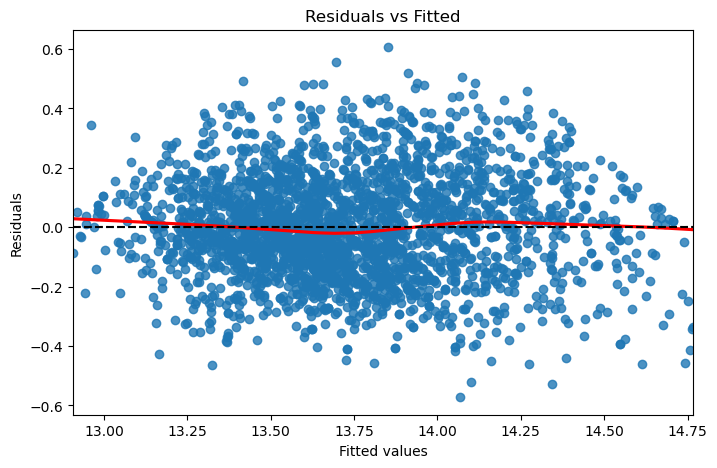

In [44]:
fitted_vals = regression2.fittedvalues
residuals = regression2.resid

plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color='black', linestyle='--')
plt.show()

* As for homoscedasticity, we got the same results and plot. This assumption is confirmed by Breusch-Pagan test, in which we reject the H0 
that the regression is homoscedastic.

* To solve this problem we applied a robust variance-covariance matrix to the 
regression as the author did. 

In [45]:
from statsmodels.stats.sandwich_covariance import cov_hc0, cov_hc3
from statsmodels.stats.contrast import ContrastResults
from statsmodels.iolib.summary2 import summary_col
robust_HC0 = regression2.get_robustcov_results(cov_type='HC0')
robust_HC3 = regression2.get_robustcov_results(cov_type='HC3')

print(summary_col([regression2, robust_HC0, robust_HC3], stars=True, model_names=['OLS', 'HC0', 'HC3']))


                                           OLS        HC0        HC3    
------------------------------------------------------------------------
Intercept                               12.5488*** 12.5488*** 12.5488***
                                        (0.0474)   (0.0478)   (0.0484)  
type[T.blockOfFlats]                    -0.0270    -0.0270    -0.0270   
                                        (0.0289)   (0.0273)   (0.0277)  
type[T.apartmentBuilding]               0.1136***  0.1136***  0.1136*** 
                                        (0.0310)   (0.0300)   (0.0304)  
hasBalcony[T.yes]                       0.0268***  0.0268***  0.0268*** 
                                        (0.0075)   (0.0072)   (0.0072)  
poiCount[T.medium]                      0.0336**   0.0336**   0.0336**  
                                        (0.0149)   (0.0146)   (0.0147)  
poiCount[T.large]                       0.1223***  0.1223***  0.1223*** 
                                        (0.0209)  

* Here we got almost the same results as in the paper.

### Multicollinearity

In [46]:
# VIF test
X = regression2.model.exog
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = regression2.model.exog_names
print("\nVIF Table:\n", vif)


VIF Table:
     VIF Factor                                 features
0   203.293204                                Intercept
1    18.537893                     type[T.blockOfFlats]
2    18.052453                type[T.apartmentBuilding]
3     1.095577                        hasBalcony[T.yes]
4     4.077735                       poiCount[T.medium]
5     4.767687                        poiCount[T.large]
6     1.984010                       hasElevator[T.yes]
7     6.052996                 ownership[T.condominium]
8     4.203836    hasElevator[T.yes]:poiCount[T.medium]
9     4.009285     hasElevator[T.yes]:poiCount[T.large]
10   28.374731                             squareMeters
11   18.593022        type[T.blockOfFlats]:squareMeters
12   19.839708   type[T.apartmentBuilding]:squareMeters
13   21.524891                     I(squareMeters ** 2)
14  123.251708                           centreDistance
15   15.677083  ownership[T.condominium]:centreDistance
16  447.064234                   I(

* Here we got the same results as in the paper. VIF should be smaller than 10, but we follow the author, remain the model unchanged. As the author explained that many of the variables that we will have to omit because of this are significant and are important for the RESET test.


# PROBLEMS WITH DATA

## Leverage, Standarized Residuals, Cook's Distance

The author uesd three methods to examine atypical observations: Leverage, Cook's Distance, and Standardized Residuals.
- Leverage points are observations that have unusual predictor (independent variable) values.
- Standardized residuals are calculated by the residuals divided by their standard deviation to identify outliers in the response variable.
- cook's distance combines information about both the leverage of the observation and its residual.

In [47]:
influence = OLSInfluence(regression1)
lev = influence.hat_matrix_diag                     
rstd = influence.resid_studentized_internal 
cookd = influence.cooks_distance[0]    

In [48]:
print(type(lev))
print(type(rstd))
print(type(cookd))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [49]:
lev = pd.Series(influence.hat_matrix_diag, index=Apartment.index)
print(type(lev))

<class 'pandas.core.series.Series'>


In [50]:
lev_threshold = 2 * len(regression1.params) / len(Apartment)
cook_threshold = 4 / len(Apartment)

num_high_leverage = np.sum(lev > lev_threshold)
num_outliers = np.sum(np.abs(rstd) > 2)
num_high_cookd = np.sum(cookd > cook_threshold)

print("Leverage threshold:", lev_threshold)
print("Cook's distance threshold:", cook_threshold)
print("Number of high leverage points:", num_high_leverage)
print("Number of standardized residual outliers:", num_outliers)
print("Number of high Cook's distance points:", num_high_cookd)

Leverage threshold: 0.008915304606240713
Cook's distance threshold: 0.0014858841010401188
Number of high leverage points: 55
Number of standardized residual outliers: 151
Number of high Cook's distance points: 187


In [51]:
diagnostics = pd.DataFrame({
    'lev': lev,
    'rstd': rstd,
    'cookd': cookd
})
nontypical = diagnostics[
    (diagnostics['lev'] > lev_threshold) &
    (np.abs(diagnostics['rstd']) > 2) &
    (diagnostics['cookd'] > cook_threshold)
].index
print("Number of nontypical observations:", len(nontypical))
print("Nontypical index values (meeting all 3 conditions):")
print(nontypical.tolist())

Number of nontypical observations: 17
Nontypical index values (meeting all 3 conditions):
[454, 469, 508, 639, 1011, 1389, 1541, 1624, 1908, 2143, 2216, 2289, 2332, 2387, 2596, 2682, 2686]


Leverage threshold = **2(k+1)/n**  
Cook's distance threshold = **4/n**  
Where:
- **k** is the number of features
- **n** is the number of observations

An observation with a leverage value greater than this threshold is considered high.  
An observation with a cook's distance higher than this threshold is when the Cook distance is a point with significant influence.  
An Observation with large absolute standardized residuals greater than |2| is a  potential outlier.

We got the same result as the original paper, 55 observations with high leverage, 151 standardized residual outliers, and 187 observations with high Cook's distance. There are 17 observations that meet the high leverage, high standard residual, and high Cook distance at the same time.

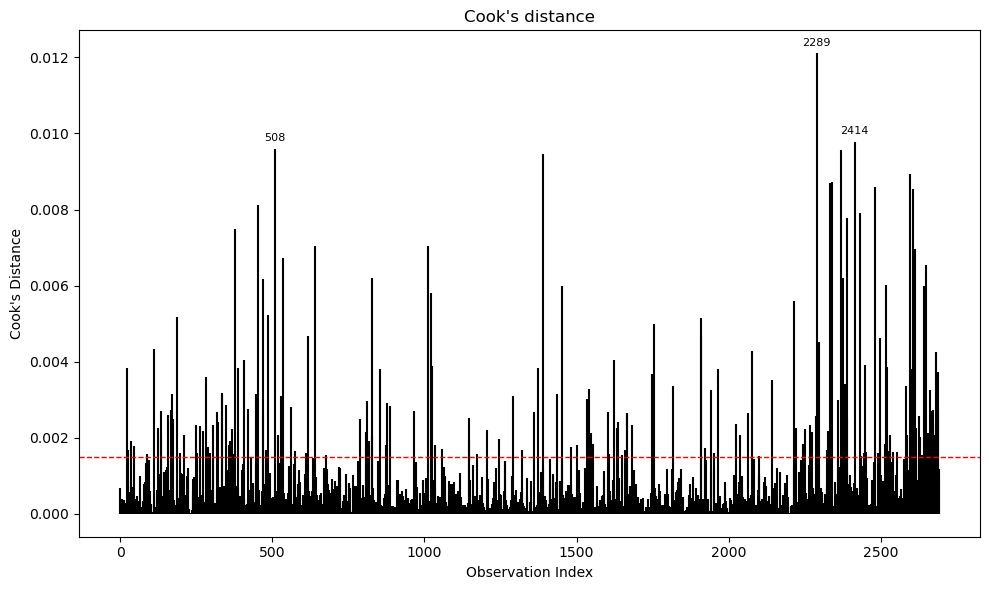

In [52]:
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cookd)), cookd, linefmt='k-', markerfmt=' ', basefmt=" ")

plt.axhline(y=cook_threshold, color='red', linestyle='--', linewidth=1)

top_n = 3
top_indices = np.argsort(cookd)[-top_n:]
for i in top_indices:
    plt.text(i, cookd.iloc[i] + 0.0002, str(i), fontsize=8, color='black', ha='center')

plt.title("Cook's distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.tight_layout()
plt.show()

The three observations with the highest Cook distance are the 2290th, 2415th, and 509th, because Python index starts from 0.

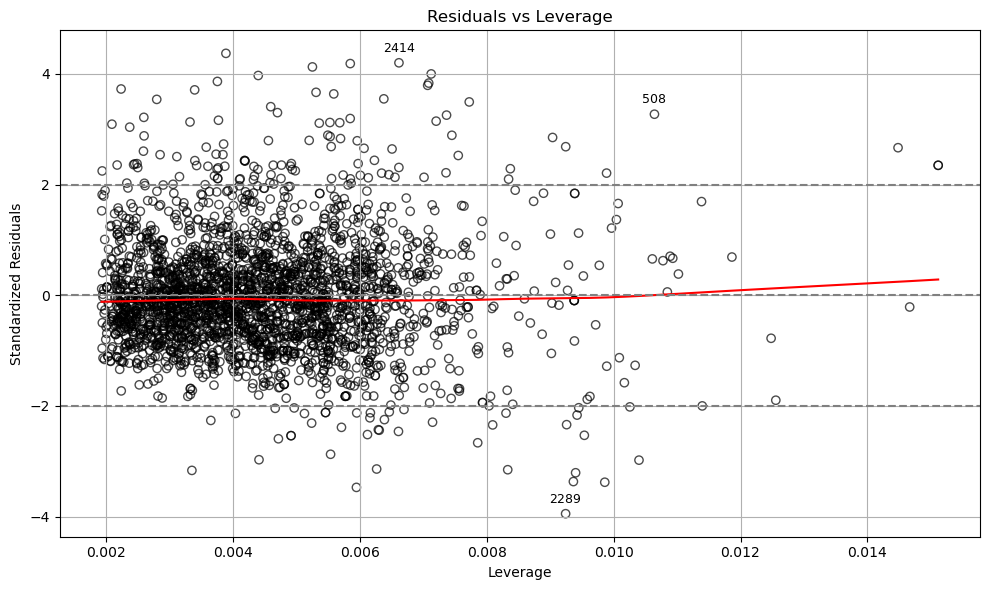

In [53]:
lowess = sm.nonparametric.lowess
trend = lowess(rstd, lev)

plt.figure(figsize=(10, 6))
plt.scatter(lev, rstd, facecolors='none', edgecolors='black', alpha=0.7)
plt.plot(trend[:, 0], trend[:, 1], color='red', linestyle='-', label='Trend')

for i in top_indices:
    plt.text(lev.iloc[i], rstd.iloc[i] + 0.2, str(i), fontsize=9, ha='center')

plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=2, color='gray', linestyle='--')
plt.axhline(y=-2, color='gray', linestyle='--')
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.title("Residuals vs Leverage")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot shows the standardized residuals plotted against the leverage values for each observation in the model. The red line shows the smoothed average of residuals across leverage values. Most points lie within the acceptable residual range (between -2 and +2) and have relatively low leverage. Observations with the highest Cook's distance are also shown in this plot. 

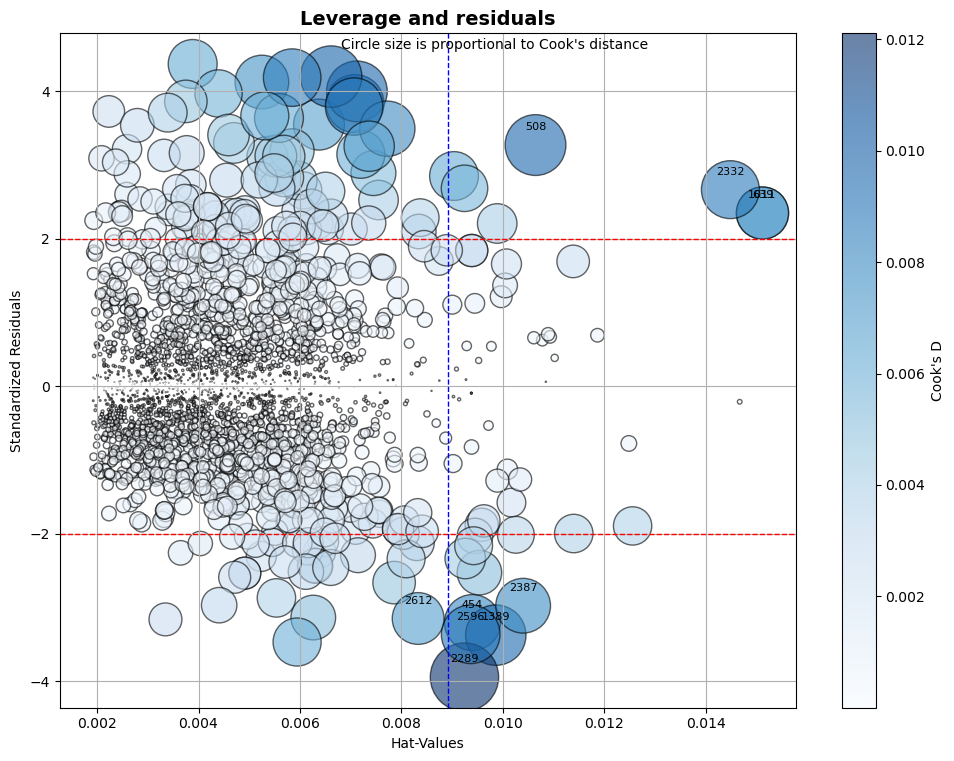

In [54]:
sizes = 200000 * diagnostics['cookd']  
colors = diagnostics['cookd']

plt.figure(figsize=(10, 8))
sc = plt.scatter(diagnostics['lev'], diagnostics['rstd'],
                 s=sizes, c=colors, cmap='Blues', alpha=0.6, edgecolors='black')

cbar = plt.colorbar(sc)
cbar.set_label("Cook's D")

lev_rank = diagnostics['lev'].rank(ascending=False)
rstd_rank = np.abs(diagnostics['rstd']).rank(ascending=False)
cookd_rank = diagnostics['cookd'].rank(ascending=False)
diagnostics['total_abnormal_rank'] = lev_rank + rstd_rank + cookd_rank

top10_idx = diagnostics.sort_values('total_abnormal_rank').head(10).index
for i in top10_idx:
    plt.text(diagnostics['lev'][i], diagnostics['rstd'][i] + 0.2,
             str(i), fontsize=8, color='black', ha='center')
    
plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
plt.axvline(x=lev_threshold, color='blue', linestyle='--', linewidth=1)

plt.title("Leverage and residuals", fontsize=14, weight='bold')
plt.xlabel("Hat-Values")
plt.ylabel("Standardized Residuals")
plt.suptitle("Circle size is proportional to Cook's distance", fontsize=10, y=0.91)
plt.grid(True)
plt.tight_layout()
plt.show()

This plot is more intuitive. The red line is the threshold of standardized residuals, and the blue line is the leverage threshold. Circles with larger sizes and darker colors indicate higher Cook distance. Based on the results of this figure, the author decided to delete the outliers 1012, 1640, and 2290.

In [55]:
print(diagnostics.loc[top10_idx][['lev', 'rstd', 'cookd', 'total_abnormal_rank']])

           lev      rstd     cookd  total_abnormal_rank
508   0.010643  3.271172  0.009593                 41.0
1389  0.009860 -3.377932  0.009469                 52.0
2289  0.009242 -3.946501  0.012107                 57.0
2332  0.014485  2.666093  0.008706                 67.0
2387  0.010399 -2.978538  0.007769                 69.0
2596  0.009365 -3.365822  0.008924                 71.0
454   0.009400 -3.206779  0.008132                 74.0
639   0.015117  2.348197  0.007053                104.5
1011  0.015117  2.348197  0.007053                104.5
2612  0.008329 -3.151892  0.006953                117.0


We rank the observations with high leverage, large standard residuals, and high Cook distances at the same time. These are the 10 most influential outliers. The top 3 are different from the authors'. For the purpose of reproduciable research,  we removed the outliers selected by the authors from the dataset. Then rerun the regressions on the most original and improved models as same as the author did.

## Reregression based on dataset that outliers was removed
### Reregression on the most original model

In [56]:
Apartment_new = Apartment.drop(index=[1011,1639,2289])
regression1_new = smf.ols('price ~ type + squareMeters + FloorType + centreDistance + poiCount + ownership + hasBalcony + hasElevator', data=Apartment_new).fit()
print(regression1_new.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     760.1
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        17:27:26   Log-Likelihood:                -36686.
No. Observations:                2689   AIC:                         7.340e+04
Df Residuals:                    2677   BIC:                         7.347e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [57]:
# RESET test (fitted)
reset_fitted_regression1_new = linear_reset(regression1_new, power=3, use_f=True)
print("\nRESET test for regession1_new (fitted):", reset_fitted_regression1_new)

# RESET test (regressor)
reset_regressor_regression1_new = linear_reset(regression1_new, power=3, use_f=True)
print("\nRESET test for regression1_new (regressor):", reset_regressor_regression1_new)

regression1_new_residuals = regression1_new.resid
jb_stat, jb_pvalue, _, _ = jarque_bera(regression1_new_residuals)
print("\nJarque-Bera test for regression1_new: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))

bp_test_regression1_new = het_breuschpagan(regression1_new_residuals, regression1_new.model.exog)
print("\nBreusch-Pagan test for regression1_new")
bp_labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
for name, value in zip(bp_labels, bp_test_regression1_new):
    print(f"{name}: {value:.4f}")


RESET test for regession1_new (fitted): <F test: F=28050.912752755637, p=0.0, df_denom=2.69e+03, df_num=2>

RESET test for regression1_new (regressor): <F test: F=28050.912752755637, p=0.0, df_denom=2.69e+03, df_num=2>

Jarque-Bera test for regression1_new: statistic = 473.5166, p-value = 0.0000

Breusch-Pagan test for regression1_new
LM Statistic: 494.4176
LM p-value: 0.0000
F Statistic: 54.8274
F p-value: 0.0000


The tests for linearity, normality, and homoscedasticity still fail. Have the same result as the authors'.

### Reregression on improved model

In [58]:
Apartment_new = Apartment.drop(index=[1011, 1639, 2289]).copy()
regression2_new = smf.ols(
                          
    '''log_price ~ squareMeters + I(squareMeters ** 2) 
       + centreDistance + I(centreDistance ** 2) 
       + I(centreDistance ** 3) + type 
       + type:squareMeters + hasBalcony 
       + poiCount + hasElevator + ownership 
       + hasElevator:poiCount + ownership:centreDistance''', 
       data=Apartment_new
).fit()

print(regression2_new.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     614.0
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        17:27:26   Log-Likelihood:                 920.63
No. Observations:                2689   AIC:                            -1805.
Df Residuals:                    2671   BIC:                            -1699.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [59]:
# RESET test (fitted)
reset_fitted_regression2_new = linear_reset(regression2_new, power=3, use_f=True)
print("\nRESET test for regession2_new (fitted):", reset_fitted_regression2_new)

# RESET test (regressor)
reset_regressor_regression2_new = linear_reset(regression2_new, power=3, use_f=True)
print("\nRESET test for regression2_new (regressor):", reset_regressor_regression2_new)

regression2_new_residuals = regression2_new.resid
jb_stat, jb_pvalue, _, _ = jarque_bera(regression2_new_residuals)
print("\nJarque-Bera test for regression2_new: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))

bp_test_regression2_new = het_breuschpagan(regression2_new_residuals, regression2_new.model.exog)
print("\nBreusch-Pagan test for regression2_new")
bp_labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
for name, value in zip(bp_labels, bp_test_regression2_new):
    print(f"{name}: {value:.4f}")


RESET test for regession2_new (fitted): <F test: F=17.300638335175506, p=3.425427940898104e-08, df_denom=2.67e+03, df_num=2>

RESET test for regression2_new (regressor): <F test: F=17.300638335175506, p=3.425427940898104e-08, df_denom=2.67e+03, df_num=2>

Jarque-Bera test for regression2_new: statistic = 14.2620, p-value = 0.0008

Breusch-Pagan test for regression2_new
LM Statistic: 103.8077
LM p-value: 0.0000
F Statistic: 6.3090
F p-value: 0.0000


After removing outliers, we got the same conclusion for the diagnostic test as the paper, except for the reset test, here we reject the null hypothesis of the regression model is correct in form.

In [60]:
reset_model_new = smf.ols(
    'log_price ~ squareMeters + squareMeters2 + squareMeters3 + '
    'centreDistance + centreDistance2 + centreDistance3 + '
    'type + type:squareMeters + hasBalcony + poiCount + '
    'hasElevator + ownership + hasElevator:poiCount + ownership:centreDistance',
    data=Apartment_new
).fit()

from statsmodels.stats.anova import anova_lm
anova_result_new = anova_lm(regression2_new, reset_model_new)
print(anova_result_new)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0    2671.0  79.385056      0.0       NaN       NaN       NaN
1    2670.0  79.384138      1.0  0.000919  0.030899  0.860479


As same as did before, manually checking by adding a non-linear variable `squareMeters3`. P-value < 0.05, indicating that the added variable does not significantly increase the explanatory power of the model, so it can be assumed that the model has no serious omitted variable bias.

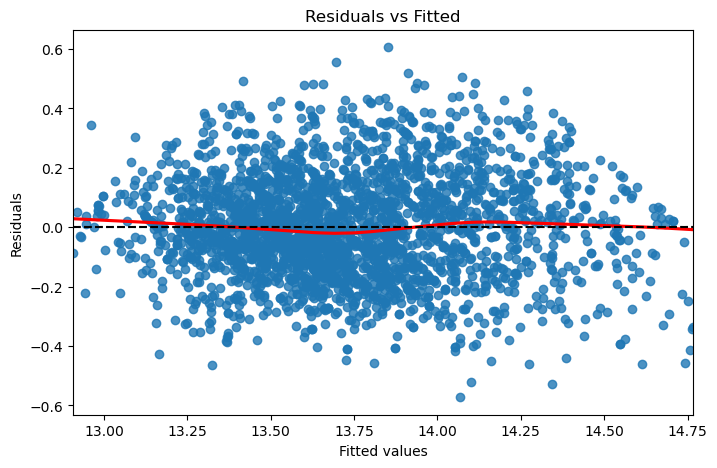

In [61]:
fitted_vals_regression2_new = regression2_new.fittedvalues
residuals_regression2_new = regression2_new.resid

plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, color='black', linestyle='--')
plt.show()

For homoscedasticity, we got the same results and plot. 

## Regression based on the dataset after removing the top 10 most influential outliers

In [62]:
Apartment_new2 = Apartment.drop(top10_idx)
regression3 = smf.ols(
                          
    '''log_price ~ squareMeters + I(squareMeters ** 2) 
       + centreDistance + I(centreDistance ** 2) 
       + I(centreDistance ** 3) + type 
       + type:squareMeters + hasBalcony 
       + poiCount + hasElevator + ownership 
       + hasElevator:poiCount + ownership:centreDistance''', 
       data=Apartment_new2
).fit()

print(regression3.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     615.5
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        17:27:27   Log-Likelihood:                 933.34
No. Observations:                2682   AIC:                            -1831.
Df Residuals:                    2664   BIC:                            -1725.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [63]:
reset_regressor_regression3 = linear_reset(regression3, power=3, use_f=True)
print("\nRESET test for regression3 (regressor):", reset_regressor_regression3)

regression3_residuals = regression3.resid
jb_stat, jb_pvalue, _, _ = jarque_bera(regression3_residuals)
print("\nJarque-Bera test for regression3: statistic = %.4f, p-value = %.4f" % (jb_stat, jb_pvalue))

bp_test_regression3 = het_breuschpagan(regression3_residuals, regression3.model.exog)
print("\nBreusch-Pagan test for regression3")
bp_labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
for name, value in zip(bp_labels, bp_test_regression2_new):
    print(f"{name}: {value:.4f}")


RESET test for regression3 (regressor): <F test: F=11.305256856004718, p=1.2909918402305572e-05, df_denom=2.66e+03, df_num=2>

Jarque-Bera test for regression3: statistic = 15.6105, p-value = 0.0004

Breusch-Pagan test for regression3
LM Statistic: 103.8077
LM p-value: 0.0000
F Statistic: 6.3090
F p-value: 0.0000


The model did not improve significantly after removing the top 10 most influential outliers based on `total_abnormal_rank`. Adjusted R-squared improves from 0.795 to 0.796. But the diagnostic test still failed. The BP test still rejects the null hypothesis of homoscedasticity. For the reset test and the JB test, the P-values are higher, but still reject the null hypothesis that the regression model is correct in form and normality of residuals.

# INTERPRETATION OF FINAL RESULTS

To sum up, the final regression is the following form：(same as the paper)
\
\begin{aligned}
\log(\text{price}) &= 12.5545 + 0.0273 \cdot \text{squareMeters} - 0.00009 \cdot \text{squareMeters}^2 \\
&\quad - 0.0606 \cdot \text{centreDistance} + 0.0041 \cdot \text{centreDistance}^2 - 0.0001 \cdot \text{centreDistance}^3 \\
&\quad - 0.0291 \cdot \text{type}_{\text{blockOfFlats}} + 0.1153 \cdot \text{type}_{\text{apartmentBuilding}} \\
&\quad + 0.0263 \cdot \text{hasBalcony} + 0.0328 \cdot \text{poiCount}_{\text{medium}} + 0.1186 \cdot \text{poiCount}_{\text{large}} \\
&\quad + 0.0954 \cdot \text{hasElevator} + 0.1290 \cdot \text{ownership}_{\text{condominium}} \\
&\quad - 0.0014 \cdot (\text{type}_{\text{blockOfFlats}} \times \text{squareMeters}) \\
&\quad - 0.0011 \cdot (\text{type}_{\text{apartmentBuilding}} \times \text{squareMeters}) \\
&\quad + 0.0035 \cdot (\text{poiCount}_{\text{medium}} \times \text{hasElevator}) \\
&\quad - 0.1224 \cdot (\text{poiCount}_{\text{large}} \times \text{hasElevator}) \\
&\quad - 0.0083 \cdot (\text{ownership}_{\text{condominium}} \times \text{centreDistance})
\end{aligned}

We got the same result as the original paper.

- **Size**：The coefficient on size (squareMeters) is 0.0273 and on size squared is –0.00009, implying a concave (inverse U-shaped) relationship between size and price. Taking the derivative of log(price) with respect to size and setting it to zero gives the turning point at: $Size = \frac{0.0273}{2 \times 0.00009} = 151.67$. This means price increases with size up to 151.67 square meters—at a rate of 2.73% per additional square meter—and decreases beyond that point at a rate of 0.009% per square meter.
- **Center Distance**: The coefficients on center distance are: linear term = –0.06, squared term = 0.0041, and cubic term = –0.0001, indicating a non-linear relationship between house price and center distance. As the distance from the city center increases, the housing price initially decreases (because the linear term is negative), but the rate of decrease slows down as the distance increases or even rises briefly (because the quadratic term is positive), and finally may accelerate again at long distances (the cubic term is negative). (This is different from the author's interpretation, which is wrong).

  According to the author's solution:  
  Taking the derivative of log(price) with respect to distance and solving for the extreme points gives:  

  $\frac{d}{d(centerDistance)} \log(\text{price}) = -0.0582 + 0.0082centerDistance - 0.0003centerDistance^2$

  Setting the derivative equal to zero:  
  $-0.0003x^2 + 0.0082x - 0.0582 = 0$

  Calculate the discriminant:  
  $\Delta = b^2 - 4ac = (0.0082)^2 - 4(-0.0003)(-0.06) = 0.00006724 - 0.000072 = -0.00000476 < 0$  
  There is no real roots, so we cannot find the exact extreme point. It is impossible to explain at which specific value (distance) from the city center the house price starts to rise or fall.
- **Apartment type**: The coefficient for blocks of flats is -0.029, meaning these apartments are priced 2.9% lower than tenements. For apartment buildings, the coefficient is 0.1153, indicating they are priced 11.53% higher than tenements.
- **Has balcony** : A coefficient 0.0263 means that apartments with a balcony have generally  2.63% higher prices than those without one.
- **Has elevator** : A coefficient 0.0954 means that apartments with an elevator have generally  9.54% higher prices than those without one.
- **Type of points of interest**: A coefficient of 0.0328 means apartments with a medium number of nearby interest points are 3.28% more expensive than those with few. A coefficient of 0.1186 means apartments with many nearby interest points are 11.86% more expensive than those with few.
- **Ownership**: A coefficient 0.129 means that apartments of condominium type ownership have generally 12.9% higher prices than those with cooperative type.
- **Interaction between apartment type and size**: The value of apartment type changes with size. For the same size, block of flats are priced 0.14% lower than tenements, and apartment buildings are 0.11% lower. This is the opposite of the earlier assumption.
- **Interaction between points type of interest and has elevator**: For apartments with an elevator, those near a medium number of interest points are 0.35% more expensive than those near a small number. However, those near a large number of interest points are 12.24% cheaper than those near a small number.
- **Interaction between ownership and center distance**: With the same distance to city center, condominium type ownership have generally  0.83% lower prices than those with cooperative type.

## HYPOTHESIS VERIFICATION

After analyzing the data, running regressions, and solving some issues, we checked our original ideas using both the results and common knowledge (same as the paper).

- The first hypothesis is rejected: tenements are not the cheapest — flats are the cheapest, and apartment buildings are the most expensive.

- The second hypothesis is also rejected: there is a non-linear relationship between size and price, but prices don’t just keep rising. They go up and then fall.

- The third hypothesis can't be rejected or confirmed because the floor type variable wasn’t significant, so we removed it from the model.

- The fourth hypothesis is rejected too: price doesn’t just drop as distance to the city center increases. It goes down first, then up.

- The fifth hypothesis is accepted: the more points of interest within 1 km, the higher the apartment price.

- The sixth, seventh, and eighth hypotheses are also accepted: apartments in condominiums are more expensive than in co-ops, those with elevators cost more than those without, and balconies add value.

## CONCLUSIONS AND SUMMARY

In conclusion, we obtained the same regression results and conclusions as the original paper as following:  
Floor type doesn’t have a significant impact on price, so it should be removed from the model. Also, apartment size and distance to the city center don’t have a simple linear relationship with price. The size of the apartment also changes how much the apartment type affects price. Whether or not the apartment has an elevator affects how the number of nearby interest points relates to price. Likewise, distance to the city center influences the effect of ownership type on price. 

The adjusted R-squared of the model is 0.795, which means our variables explain 79.5% of the price differences. So, we can use this model to predict prices fairly well. However, since about 20% of the price variation is still unexplained, it would be useful to explore more variables—maybe ones not included here—or look at how prices differ in other cities or countries.